In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from MIL_functions import data_analysis,molecule_analysis
from rdkit import Chem
from sklearn.decomposition import PCA
from IPython import display as ICD

In [2]:
## done to hide an unneccesary error
pd.options.mode.chained_assignment = None  # default='warn'

# Aromatic Amine data analysis

In [3]:
int_results_raw = {
    'SEC':      pd.concat([pd.read_pickle('model_results/internal/MIL_aromatic_amine_cv_SEC.pk1'),pd.read_pickle('model_results/internal/MIL_aromatic_amine_cv_SEC_MORGAN.pk1')]),
    'LHS' :      pd.concat([pd.read_pickle('model_results/internal/MIL_aromatic_amine_cv_LSH.pk1'),pd.read_pickle('model_results/internal/MIL_aromatic_amine_cv_LSH_MORGAN.pk1')]),
    'scaffold':  pd.concat([pd.read_pickle('model_results/internal/MIL_aromatic_amine_cv_Scaffold.pk1'),pd.read_pickle('model_results/internal/MIL_aromatic_amine_cv_Scaffold_MORGAN.pk1')]),
    'random':    pd.concat([pd.read_pickle('model_results/internal/MIL_aromatic_amine_cv_results.pk1'),pd.read_pickle('model_results/internal/MIL_aromatic_amine_cv_results_MORGAN.pk1')])
}
ext_results_raw = {
    'SEC':      pd.concat([pd.read_pickle('model_results\external\ext_val_results_SEC_stratified.pk1'),pd.read_pickle('model_results\external\ext_val_results_SEC_stratified_MORGAN.pk1')]),
    'LHS':      pd.concat([pd.read_pickle('model_results\external\ext_val_results_LSH_stratified.pk1'),pd.read_pickle('model_results\external\ext_val_results_LSH_stratified_MORGAN.pk1')]),
    'scaffold': pd.concat([pd.read_pickle('model_results\external\ext_val_results_scaffold_stratified.pk1'),pd.read_pickle('model_results\external\ext_val_results_scaffold_stratified_MORGAN.pk1')]),
    'random':   pd.concat([pd.read_pickle('model_results\external\ext_val_results.pk1'),pd.read_pickle('model_results\external\ext_val_results_MORGAN.pk1')])
}
macro_results={}; micro_results={}; int_results={}; ext_results={}

for data in int_results_raw:
    int_results[data] = data_analysis.pickle_transform(int_results_raw[data])
    macro_results[data],micro_results[data] = data_analysis.macro_mirco_mean_stdv(int_results[data])
macro_results = data_analysis.get_AUROC(data_dict=int_results_raw, paste_dict=macro_results)
micro_results = data_analysis.get_AUROC(data_dict=int_results_raw, paste_dict=micro_results)

for data in ext_results_raw:
    ext_results_raw[data]['model'] = ext_results_raw[data]['model'].apply(lambda x:x.replace('total_data_',''))
    ext_results[data] = data_analysis.pickle_transform(ext_results_raw[data])
    ext_results[data] = data_analysis.ext_val_metrics(ext_results[data])
ext_results = data_analysis.get_AUROC(data_dict=ext_results_raw, paste_dict=ext_results)

density pca

In [4]:
pca = PCA(n_components=2)
data = pd.read_pickle('data\encoded\encoded_data.pk1')
X1 = data['MACCS'].to_list()
data = pd.read_pickle('data\encoded\encoded_data_hansen.pk1')
X2 = data['MACCS'].to_list()
pca.fit(X1+X2)
Xt1 = pca.transform(X1)
Xt2 = pca.transform(X2)

x_range = [-4,4];y_range=[-3.25,3.5]

(1.968503937007874, 1.968503937007874)


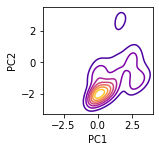

In [22]:
data_analysis.density_PCA(Xt = Xt1, name = '',size=(5,5),font=1,x_range=x_range,y_range=y_range).savefig('final results/aromatic amine.png', dpi=500,bbox_inches='tight')

(1.968503937007874, 1.968503937007874)


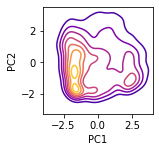

In [23]:
data_analysis.density_PCA(Xt = Xt2, name = '',size=(5,5),font=1,x_range=x_range,y_range=y_range).savefig('final results/hansen.png', dpi=500,bbox_inches='tight')

internal validation

In [7]:
first = True
for grouping in micro_results:
    results = micro_results[grouping]
    results['Grouping'] = grouping
    if first:
        first=False
        output = results
    else:
        output = pd.concat([output,results])
output['model'] = output['model'].str.replace('-','_')
output[['Model','Kernel']] = output['model'].str.split('_',expand=True)
output["Cohen's kappa"] = output['CK2']; output["Encoding"] = output['encoding']
output = output[['Encoding','Grouping','Kernel','Model','sensitivity','specificity','accuracy','AUROC','F1',"Cohen's kappa"]]
output = output.sort_values(by=['Encoding']).reset_index(drop=True)
output

,Encoding,Grouping,Kernel,Model,sensitivity,specificity,accuracy,AUROC,F1,Cohen's kappa
0,MACCS,SEC,linear,MISVM,0.910526,0.355822,0.446418,0.80652,0.349495,0.080489
1,MACCS,LHS,linear,sbMIL,0.985294,0.337477,0.387966,0.60058,0.200599,0.043932
2,MACCS,LHS,linear,sMIL,0.714646,0.577640,0.702006,0.65265,0.813218,0.664207
3,MACCS,scaffold,polynomial,MISVM,0.846787,0.676083,0.794842,0.80366,0.851698,0.704069
4,MACCS,LHS,quadratic,MISVM,0.895028,0.741425,0.844986,0.86521,0.886177,0.771567
...,...,...,...,...,...,...,...,...,...,...
115,Morgan,LHS,quadratic,NSK,0.863359,0.736053,0.821585,0.83775,0.866707,0.733770
116,Morgan,LHS,quadratic,SIL,0.797890,0.868239,0.811749,0.89153,0.871909,0.757454
117,Morgan,LHS,quadratic,MISVM,0.878800,0.737887,0.830328,0.88933,0.871721,0.742795
118,Morgan,scaffold,quadratic,sMIL,0.880499,0.460366,0.616940,0.67313,0.631441,0.312408


external validation

In [8]:
output = {}
for grouping in ext_results:
    results = ext_results[grouping]
    results['model'] = results['model'].str.replace('NSK_polynomial','MIL')
    results = results[results['model'].isin(['TPOT','MIL'])]
    results["Cohen's kappa"] = results['CK2']
    results['Model'] = [' '.join(i) for i in zip(results["encoding"].map(str),results["model"])]
    for metric in ['sensitivity','specificity','accuracy','AUROC','F1',"Cohen's kappa"]:
        results[grouping] = results[metric]
        if not metric in output:
            output[metric] = results[['Model',grouping]]
        else:
            output[metric] = output[metric].merge(results[['Model',grouping]],on='Model')

for metric in output:
    print('*'*(len(metric)+8));print("*** "+metric+(" ***"));print('*'*(len(metric)+8))
    ICD.display(output[metric])

*******************
*** sensitivity ***
*******************


,Model,SEC,LHS,scaffold,random
0,MACCS TPOT,0.867925,0.753623,0.806452,0.833333
1,Morgan TPOT,0.850746,0.836364,0.695652,0.875000
2,MACCS MIL,0.746479,0.721311,0.641509,0.833333
3,Morgan MIL,0.866667,0.800000,0.645161,0.888889


*******************
*** specificity ***
*******************


,Model,SEC,LHS,scaffold,random
0,MACCS TPOT,0.606061,0.588235,0.625000,0.714286
1,Morgan TPOT,0.833333,0.583333,0.409091,0.821429
2,MACCS MIL,0.600000,0.433333,0.289474,0.769231
3,Morgan MIL,0.709677,0.527778,0.275862,0.827586


****************
*** accuracy ***
****************


,Model,SEC,LHS,scaffold,random
0,MACCS TPOT,0.767442,0.720930,0.755814,0.804598
1,Morgan TPOT,0.846154,0.736264,0.626374,0.858696
2,MACCS MIL,0.714286,0.626374,0.494505,0.815217
3,Morgan MIL,0.813187,0.692308,0.527473,0.869565


*************
*** AUROC ***
*************


,Model,SEC,LHS,scaffold,random
0,MACCS TPOT,0.77746,0.65788,0.60954,0.82030
1,Morgan TPOT,0.82869,0.70219,0.50546,0.82919
2,MACCS MIL,0.60710,0.54098,0.38306,0.76335
3,Morgan MIL,0.81038,0.68033,0.50437,0.86013


**********
*** F1 ***
**********


,Model,SEC,LHS,scaffold,random
0,MACCS TPOT,0.821429,0.812500,0.826446,0.866142
1,Morgan TPOT,0.890625,0.793103,0.738462,0.896000
2,MACCS MIL,0.803030,0.721311,0.596491,0.866142
3,Morgan MIL,0.859504,0.758621,0.650407,0.903226


*********************
*** Cohen's kappa ***
*********************


,Model,SEC,LHS,scaffold,random
0,MACCS TPOT,0.638352,0.641915,0.656654,0.737626
1,Morgan TPOT,0.785990,0.581689,0.493036,0.793935
2,MACCS MIL,0.622105,0.442623,0.183538,0.736789
3,Morgan MIL,0.718266,0.511971,0.302868,0.807598


ROC curves

In [9]:
MACCS_sens,Morgan_sens,MACCS_spec,Morgan_spec = data_analysis.get_ROC_points( data_dict = ext_results_raw, specific_models=['TPOT','NSK_polynomial'])
for encoding,sens,spec in [['MACCS',MACCS_sens,MACCS_spec],['Morgan',Morgan_sens,Morgan_spec]]:
    print('*'*(len(encoding)+8));print("*** "+encoding+(" ***"));print('*'*(len(encoding)+8))
    name_order = [name for i in range(len(list(sens.columns))) for name in [list(spec.columns)[i],list(sens.columns)[i]]]
    data = pd.concat([spec,sens],axis=1)
    data = data[name_order]
    data.columns = data.columns.str.replace('_', ' ')
    ## adding in random chance line
    data['random chance sensitivity'] = 1;data['random chance specificity'] = 1
    ## adding 0,0 and 1,1 points to help with graphing and theory
    data = data.append(pd.Series(0, index=data.columns), ignore_index=True)
    data.loc[-1] = pd.Series(1, index=data.columns);data.index = data.index + 1 # adding a row

    # data = data.columns.rename({column: " ".join(column.split(' ')[1:2,-1]) for column in list(data.columns)})
    data.loc[-1] = [' '.join(list((name.split(' ')[:-1]))).replace('NSK polynomial','MIL') for name in list(data.columns)]  ## done for graphing
    data = data.sort_index().reset_index(drop=True)
    order = [model+" "+grouping+" "+axis for model in ['NSK polynomial','TPOT'] for grouping in ['SEC','LHS','scaffold','random'] for axis in ['specificity','sensitivity']]+['random chance specificity','random chance sensitivity']
    data = data[order]
    ICD.display(data)

*************
*** MACCS ***
*************


C:\Users\user.000\AppData\Local\Temp\ipykernel_21928\296728126.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(0, index=data.columns), ignore_index=True)


,NSK polynomial SEC specificity,NSK polynomial SEC sensitivity,NSK polynomial LHS specificity,NSK polynomial LHS sensitivity,NSK polynomial scaffold specificity,NSK polynomial scaffold sensitivity,NSK polynomial random specificity,NSK polynomial random sensitivity,TPOT SEC specificity,TPOT SEC sensitivity,TPOT LHS specificity,TPOT LHS sensitivity,TPOT scaffold specificity,TPOT scaffold sensitivity,TPOT random specificity,TPOT random sensitivity,random chance specificity,random chance sensitivity
0,MIL SEC,MIL SEC,MIL LHS,MIL LHS,MIL scaffold,MIL scaffold,MIL random,MIL random,TPOT SEC,TPOT SEC,TPOT LHS,TPOT LHS,TPOT scaffold,TPOT scaffold,TPOT random,TPOT random,random chance,random chance
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1
2,0.966667,1.0,0.966667,1.0,0.966667,1.0,0.967742,1.0,1.0,0.983051,0.962963,1.0,0.925926,0.898305,0.961538,1.0,1,1
3,0.866667,0.967213,0.966667,1.0,0.966667,1.0,0.967742,1.0,0.888889,0.898305,0.925926,1.0,0.925926,0.898305,0.923077,1.0,1,1
4,0.566667,0.819672,0.966667,1.0,0.966667,1.0,0.967742,1.0,0.777778,0.881356,0.925926,1.0,0.925926,0.898305,0.846154,1.0,1,1
5,0.233333,0.360656,0.966667,1.0,0.966667,1.0,0.967742,1.0,0.703704,0.813559,0.925926,1.0,0.925926,0.898305,0.769231,1.0,1,1
6,0.066667,0.131148,0.933333,1.0,0.966667,0.983607,0.967742,1.0,0.592593,0.813559,0.925926,1.0,0.925926,0.898305,0.615385,0.967213,1,1
7,0.033333,0.04918,0.933333,1.0,0.966667,0.967213,0.967742,1.0,0.37037,0.79661,0.925926,0.949153,0.925926,0.898305,0.538462,0.967213,1,1
8,0.033333,0.032787,0.933333,1.0,0.966667,0.95082,0.935484,1.0,0.296296,0.79661,0.925926,0.949153,0.925926,0.898305,0.538462,0.967213,1,1
9,0.033333,0.0,0.933333,1.0,0.933333,0.918033,0.935484,1.0,0.296296,0.779661,0.777778,0.915254,0.444444,0.847458,0.5,0.967213,1,1


**************
*** Morgan ***
**************


C:\Users\user.000\AppData\Local\Temp\ipykernel_21928\296728126.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.Series(0, index=data.columns), ignore_index=True)


,NSK polynomial SEC specificity,NSK polynomial SEC sensitivity,NSK polynomial LHS specificity,NSK polynomial LHS sensitivity,NSK polynomial scaffold specificity,NSK polynomial scaffold sensitivity,NSK polynomial random specificity,NSK polynomial random sensitivity,TPOT SEC specificity,TPOT SEC sensitivity,TPOT LHS specificity,TPOT LHS sensitivity,TPOT scaffold specificity,TPOT scaffold sensitivity,TPOT random specificity,TPOT random sensitivity,random chance specificity,random chance sensitivity
0,MIL SEC,MIL SEC,MIL LHS,MIL LHS,MIL scaffold,MIL scaffold,MIL random,MIL random,TPOT SEC,TPOT SEC,TPOT LHS,TPOT LHS,TPOT scaffold,TPOT scaffold,TPOT random,TPOT random,random chance,random chance
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1
2,0.966667,1.0,0.966667,1.0,1.0,0.983607,0.967742,1.0,0.966667,0.983607,0.966667,1.0,0.966667,1.0,0.967742,1.0,1,1
3,0.966667,1.0,0.933333,1.0,0.966667,0.967213,0.935484,1.0,0.866667,0.983607,0.366667,0.754098,0.733333,0.852459,0.290323,0.967213,1,1
4,0.966667,1.0,0.9,1.0,0.933333,0.967213,0.903226,1.0,0.7,0.967213,0.366667,0.754098,0.7,0.819672,0.290323,0.967213,1,1
5,0.966667,1.0,0.9,1.0,0.9,0.918033,0.903226,1.0,0.633333,0.967213,0.366667,0.754098,0.7,0.819672,0.290323,0.967213,1,1
6,0.966667,1.0,0.9,1.0,0.8,0.819672,0.83871,1.0,0.566667,0.967213,0.366667,0.754098,0.7,0.803279,0.290323,0.967213,1,1
7,0.966667,1.0,0.9,1.0,0.733333,0.737705,0.806452,0.983607,0.566667,0.95082,0.366667,0.754098,0.7,0.803279,0.290323,0.967213,1,1
8,0.966667,1.0,0.866667,1.0,0.7,0.557377,0.709677,0.983607,0.533333,0.95082,0.3,0.754098,0.7,0.786885,0.290323,0.967213,1,1
9,0.933333,0.983607,0.866667,0.95082,0.6,0.491803,0.516129,0.967213,0.5,0.95082,0.3,0.754098,0.7,0.786885,0.290323,0.967213,1,1


# Hansen Data

In [10]:
hansen_raw = {
    'random':   pd.read_pickle('model_results/hansen/rscv_random_hansen_results.pk1')
}
hansen_macro_results={}; hansen_micro_results={}; hansen_results={}

for data in hansen_raw:
    hansen_results[data] = data_analysis.pickle_transform(hansen_raw[data])
    hansen_macro_results[data],hansen_micro_results[data] = data_analysis.macro_mirco_mean_stdv(hansen_results[data])
hansen_macro_results = data_analysis.get_AUROC(data_dict=hansen_raw, paste_dict=hansen_macro_results)
hansen_micro_results = data_analysis.get_AUROC(data_dict=hansen_raw, paste_dict=hansen_micro_results)

hansen_results = hansen_micro_results['random']

MACCS NSK linear is missing data
Morgan NSK linear is missing data
MACCS NSK polynomial is missing data
Morgan NSK polynomial is missing data


internal validation

In [11]:
output['sensitivity']

,Model,SEC,LHS,scaffold,random
0,MACCS TPOT,0.867925,0.753623,0.806452,0.833333
1,Morgan TPOT,0.850746,0.836364,0.695652,0.875000
2,MACCS MIL,0.746479,0.721311,0.641509,0.833333
3,Morgan MIL,0.866667,0.800000,0.645161,0.888889


In [12]:
output['sensitivity'].rename(columns=output['sensitivity'].iloc[0]).drop(output['sensitivity'].index[0])

,MACCS TPOT,0.8679245283018868,0.7536231884057971,0.8064516129032258,0.8333333333333334
1,Morgan TPOT,0.850746,0.836364,0.695652,0.875000
2,MACCS MIL,0.746479,0.721311,0.641509,0.833333
3,Morgan MIL,0.866667,0.800000,0.645161,0.888889


In [13]:
results[metric].T

0    0.737626
1    0.793935
4    0.736789
5    0.807598
Name: Cohen's kappa, dtype: float64

In [14]:
hansen_results
results = hansen_results
results["Cohen's kappa"] = results['CK2']
results['Model'] = [' '.join(i) for i in zip(results["encoding"].map(str),results["model"])]

output = {}
for metric in ['sensitivity','specificity','accuracy','AUROC','F1',"Cohen's kappa"]:
    output[metric] = pd.DataFrame(data=results[['Model',metric]].T)
    output[metric] = output[metric].rename(columns=output[metric].iloc[0]).drop(output[metric].index[0])
    ICD.display(output[metric])

,MACCS NSK linear,Morgan NSK linear,MACCS NSK polynomial,Morgan NSK polynomial
sensitivity,0.760175,0.809508,0.78599,0.798827


,MACCS NSK linear,Morgan NSK linear,MACCS NSK polynomial,Morgan NSK polynomial
specificity,0.677439,0.712424,0.729592,0.755869


,MACCS NSK linear,Morgan NSK linear,MACCS NSK polynomial,Morgan NSK polynomial
accuracy,0.718063,0.759387,0.758801,0.778786


,MACCS NSK linear,Morgan NSK linear,MACCS NSK polynomial,Morgan NSK polynomial
AUROC,0.77654,0.80651,0.77108,0.81922


,MACCS NSK linear,Morgan NSK linear,MACCS NSK polynomial,Morgan NSK polynomial
F1,0.725859,0.764976,0.771449,0.793938


,MACCS NSK linear,Morgan NSK linear,MACCS NSK polynomial,Morgan NSK polynomial
Cohen's kappa,0.452164,0.530791,0.542596,0.587706


external validation

In [15]:
commerical_models = {
    'DEREK' :   {'sensitivity': 0.809,'specificity': 0.591,'accuracy': 0.737},
    'LSMA' :    {'sensitivity': 0.678,'specificity': 0.638,'accuracy': 0.664},
    'Toxtree' : {'sensitivity': 0.852,'specificity': 0.531,'accuracy': 0.746},
    'MC4PC' :   {'sensitivity': 0.746,'specificity': 0.740,'accuracy': 0.744}
}
output = pd.concat([results[['Model','sensitivity','specificity','accuracy']],pd.DataFrame(commerical_models).T.reset_index().rename(columns={'index': 'Model'})]).reset_index(drop=True).round(3)
output

,Model,sensitivity,specificity,accuracy
0,MACCS NSK linear,0.760,0.677,0.718
1,Morgan NSK linear,0.810,0.712,0.759
2,MACCS NSK polynomial,0.786,0.730,0.759
3,Morgan NSK polynomial,0.799,0.756,0.779
4,DEREK,0.809,0.591,0.737
5,LSMA,0.678,0.638,0.664
6,Toxtree,0.852,0.531,0.746
7,MC4PC,0.746,0.740,0.744


# Molecule group analysis

In [16]:
morgan_data,maccs_data = molecule_analysis.label_data(input_data=hansen_raw['random'],encodings=['Morgan','MACCS'],models=['NSK polynomial'],encoded_data_path="data/encoded/encoded_data_hansen.pk1").values()

molecule_groups = {
    'polyaromatic': molecule_analysis.polyaromatic_check,
    'PAB'   :   molecule_analysis.phenol_aniline_benzamide_check,
    'azido': molecule_analysis.azide_check,
    'halides': molecule_analysis.alkyl_alkenyl_halide_check,
    'quinolines': molecule_analysis.quinoline_check,
    'aromatic nitro': molecule_analysis.aromatic_nitro_check,
    'furan': molecule_analysis.furan_wo_nitro_check

}
print('MORGAN RESULTS')
for name in molecule_groups:
    print('*'*(len(name)+8));print("*** "+name+(" ***"));print('*'*(len(name)+8))
    group = molecule_analysis.molecule_group_analysis(data=morgan_data, function=molecule_groups[name])
    if type(group) == pd.core.frame.DataFrame:
        group = data_analysis.ext_val_metrics(data_analysis.pickle_transform(group))
    else:
        group = ''
    ICD.display(group[['sensitivity','specificity','accuracy']])

MORGAN RESULTS
********************
*** polyaromatic ***
********************
Number of group: 96.5
Ames +: 825         Ames -: 140         Total: 965         Ames + (%): 85.492


,sensitivity,specificity,accuracy
0,0.89601,0.391304,0.823834


***********
*** PAB ***
***********
Number of group: 45.0
Ames +: 191         Ames -: 259         Total: 450         Ames + (%): 42.444


,sensitivity,specificity,accuracy
0,0.688995,0.804979,0.751111


*************
*** azido ***
*************
Number of group: 6.3
Ames +: 61          Ames -: 2           Total: 63           Ames + (%): 96.825


,sensitivity,specificity,accuracy
0,0.966102,0.0,0.904762


***************
*** halides ***
***************
Number of group: 6.8
Ames +: 35          Ames -: 33          Total: 68          Ames + (%): 51.471


,sensitivity,specificity,accuracy
0,0.72973,0.741935,0.735294


******************
*** quinolines ***
******************
Number of group: 14.0
Ames +: 66          Ames -: 74          Total: 140          Ames + (%): 47.143


,sensitivity,specificity,accuracy
0,0.675325,0.777778,0.721429


**********************
*** aromatic nitro ***
**********************
Number of group: 77.1
Ames +: 631         Ames -: 140         Total: 771         Ames + (%): 81.842


,sensitivity,specificity,accuracy
0,0.886503,0.554622,0.835279


*************
*** furan ***
*************
Number of group: 3.8
Ames +: 9           Ames -: 29          Total: 38          Ames + (%): 23.684


,sensitivity,specificity,accuracy
0,0.266667,0.782609,0.578947
